# Results for GDF+PCA+GRU 

We use grid search for parameters:

* units = [4, 8, 16, 32]
* kernel_regularizations = [0.0, 0.001, 0.0001, 0.01]
* n_steps = [1, 4, 8, 16]


In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM


from keras.models import Sequential, model_from_json
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence


import warnings
import numpy as np
from collections import OrderedDict

import os

from lob_data_utils import lob, db_result, gdf_pca, model, stocks_numbers
from lob_data_utils.svm_calculation import lob_svm


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
data_dir = 'res_gdf_pca_gru/'
data_dir_que_log = '../queue_imbalance/res_que_log'
if_should_savefig = False

In [3]:
df_log = pd.DataFrame()
for f in os.listdir(data_dir_que_log):
    if 'csv' not in f:
        continue
    d = pd.read_csv(os.path.join(data_dir_que_log, f))
    df_log = df_log.append(d)

In [4]:
df_res = pd.DataFrame()
for f in os.listdir(data_dir):
    if 'csv' not in f:
        continue
    d = pd.read_csv(os.path.join(data_dir, f))
    d['filename'] = [f for i in range(len(d))]
    number_of_units = []
    for i, row in d.iterrows():
        unit = row['unit'].split(':')[0][1:]
        number_of_units.append(unit)
    d['number_of_units'] = number_of_units
    df_res = df_res.append(d)

columns = ['matthews', 'test_matthews', 'stock', 'unit']
df_best = df_res.sort_values(by='matthews', ascending=False).groupby(['stock']).head(1)
df_best = pd.merge(df_best, df_log, on='stock', suffixes=['_gru', '_log'])
df_best.index = df_best['stock']

In [5]:
df_best[['r', 's', 'unit', 'n_steps', 'kernel_reg', 'train_matthews_gru',
         'matthews_gru', 'test_matthews_gru', 'test_matthews_log']]

,r,s,unit,n_steps,kernel_reg,train_matthews_gru,matthews_gru,test_matthews_gru,test_matthews_log
stock,,,,,,,,,
2748,0.01,0.10,"(32: tanh, 1)",16,0.0000,0.265068,0.200579,0.146445,0.134365
3879,0.01,0.10,"(32: tanh, 1)",4,0.0010,0.155667,0.158942,0.120586,0.120715
9761,0.01,0.10,"(8: tanh, 1)",16,0.0000,0.153762,0.158637,0.111831,0.107395
4851,0.01,0.10,"(32: tanh, 1)",16,0.0010,0.178745,0.155013,0.164520,0.138621
10470,0.01,0.10,"(32: tanh, 1)",1,0.0001,0.132563,0.150017,0.137040,0.127305
4320,0.10,0.10,"(32: tanh, 1)",16,0.0010,0.165089,0.149794,0.137224,0.133488
2730,0.25,0.25,"(32: tanh, 1)",4,0.0000,0.148255,0.142332,0.166390,0.150063
4799,0.25,0.25,"(32: tanh, 1)",8,0.0100,0.135924,0.137183,0.133901,0.124104
1431,0.25,0.25,"(16: tanh, 1)",16,0.0000,0.135917,0.136941,0.123672,0.123369


In [6]:
df_best[['r', 's', 'train_roc_auc_gru',
         'roc_auc_gru', 'test_roc_auc_gru', 'test_roc_auc_log']]

,r,s,train_roc_auc_gru,roc_auc_gru,test_roc_auc_gru,test_roc_auc_log
stock,,,,,,
2748,0.01,0.10,0.676904,0.620273,0.602292,0.596648
3879,0.01,0.10,0.586071,0.588576,0.565639,0.565942
9761,0.01,0.10,0.584015,0.582593,0.560776,0.558399
4851,0.01,0.10,0.621725,0.610910,0.617953,0.600698
10470,0.01,0.10,0.576241,0.585441,0.577046,0.571647
4320,0.10,0.10,0.588751,0.581109,0.571216,0.572275
2730,0.25,0.25,0.587132,0.582909,0.595637,0.586418
4799,0.25,0.25,0.575963,0.577476,0.575352,0.569974
1431,0.25,0.25,0.575800,0.574763,0.567309,0.567813


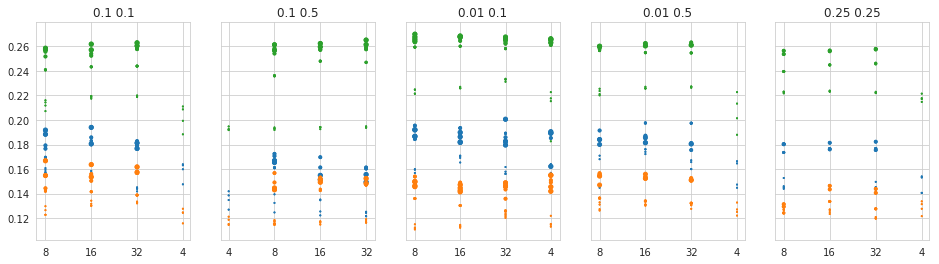

In [7]:
fig, ax = plt.subplots(1, 5, figsize=(16, 4), sharey=True)
i = 0
for r, s in stocks_numbers.rs_params:
    d = df_res[df_res['r'] == r] 
    d = d[d['s'] == s]
    d = d[d['stock'] == 2748]
    ax[i].scatter(d['number_of_units'], d['matthews'], d['n_steps'])
    ax[i].scatter(d['number_of_units'], d['test_matthews'], d['n_steps'])
    ax[i].scatter(d['number_of_units'], d['train_matthews'], d['n_steps'])

    ax[i].set_title(f'{r} {s}')
    i += 1

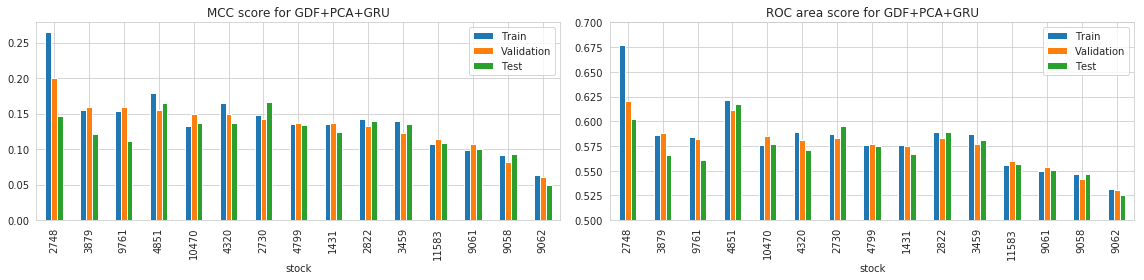

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
df_best[['train_matthews_gru', 'matthews_gru', 'test_matthews_gru']].plot(kind='bar', ax=ax1)
ax1.legend(['Train', 'Validation', 'Test'])
ax1.set_title('MCC score for GDF+PCA+GRU')

df_best[['train_roc_auc_gru', 'roc_auc_gru', 'test_roc_auc_gru']].plot(kind='bar', ax=ax2)
ax2.legend(['Train', 'Validation', 'Test'])
ax2.set_ylim(0.5, 0.7)
ax2.set_title('ROC area score for GDF+PCA+GRU')
plt.tight_layout()
if if_should_savefig:
    plt.savefig('gdf_pca_gru_mcc_roc_scores_bar.png')

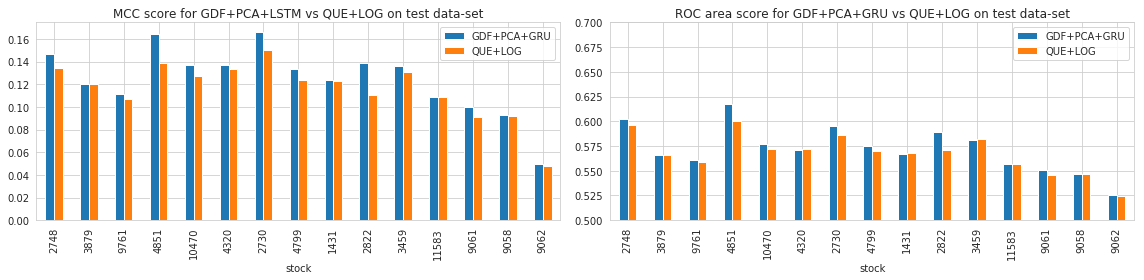

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
df_best[['test_matthews_gru', 'test_matthews_log']].plot(kind='bar', ax=ax1)
ax1.legend(['GDF+PCA+GRU', 'QUE+LOG'])
ax1.set_title('MCC score for GDF+PCA+LSTM vs QUE+LOG on test data-set')

df_best[['test_roc_auc_gru', 'test_roc_auc_log']].plot(kind='bar', ax=ax2)
ax2.legend(['GDF+PCA+GRU', 'QUE+LOG'])
ax2.set_ylim(0.5, 0.7)
ax2.set_title('ROC area score for GDF+PCA+GRU vs QUE+LOG on test data-set')
plt.tight_layout()
if if_should_savefig:
    plt.savefig('gdf_pca_gru_que_log_mcc_roc_scores_bar.png')

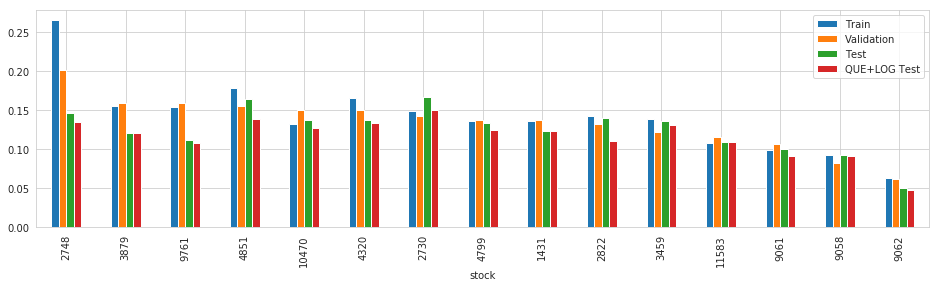

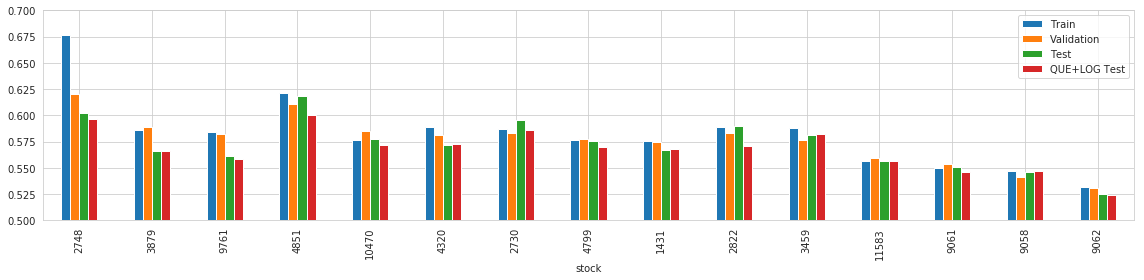

In [10]:
df_best[['train_matthews_gru', 'matthews_gru', 'test_matthews_gru', 'test_matthews_log']].plot(kind='bar', figsize=(16, 4))
plt.legend(['Train', 'Validation', 'Test', 'QUE+LOG Test'])

df_best[['train_roc_auc_gru', 'roc_auc_gru', 'test_roc_auc_gru', 'test_roc_auc_log']].plot(kind='bar', figsize=(16, 4))
plt.legend(['Train', 'Validation', 'Test', 'QUE+LOG Test'])
plt.ylim(0.5, 0.7)
plt.tight_layout()

In [11]:
print(df_best[['train_matthews_gru', 'matthews_gru', 'test_matthews_gru', 
        'train_roc_auc_gru', 'roc_auc_gru', 'test_roc_auc_gru']].describe().to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  train\_matthews\_gru &  matthews\_gru &  test\_matthews\_gru &  train\_roc\_auc\_gru &  roc\_auc\_gru &  test\_roc\_auc\_gru \\
\midrule
count &           15.000000 &     15.000000 &          15.000000 &          15.000000 &    15.000000 &         15.000000 \\
mean  &            0.140970 &      0.133902 &           0.124522 &           0.582269 &     0.576587 &          0.572123 \\
std   &            0.045715 &      0.033736 &           0.029557 &           0.034132 &     0.023341 &          0.023543 \\
min   &            0.063122 &      0.061404 &           0.049816 &           0.531722 &     0.530545 &          0.525058 \\
25\%   &            0.120158 &      0.118602 &           0.110348 &           0.565937 &     0.567216 &          0.558731 \\
50\%   &            0.139009 &      0.137183 &           0.133901 &           0.584015 &     0.581109 &          0.571216 \\
75\%   &            0.154714 &      0.152515 &           0.138252 &          

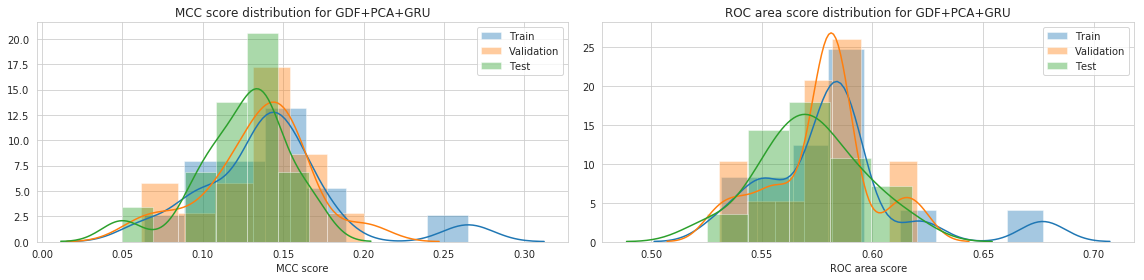

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
sns.distplot(df_best['train_matthews_gru'], label='Train', ax=ax1)
sns.distplot(df_best['matthews_gru'], label='Validation', ax=ax1)
sns.distplot(df_best['test_matthews_gru'], label='Test', ax=ax1)
ax1.legend(['Train', 'Validation', 'Test'])
ax1.set_title('MCC score distribution for GDF+PCA+GRU')
ax1.set_xlabel('MCC score')

sns.distplot(df_best['train_roc_auc_gru'], label='Train', ax=ax2)
sns.distplot(df_best['roc_auc_gru'], label='Validation', ax=ax2)
sns.distplot(df_best['test_roc_auc_gru'], label='Test', ax=ax2)
ax2.legend(['Train', 'Validation', 'Test'])
ax2.set_title('ROC area score distribution for GDF+PCA+GRU')
ax2.set_xlabel('ROC area score')

plt.tight_layout()
if if_should_savefig:
    plt.savefig('gdf_pca_gru_score_dist.png')

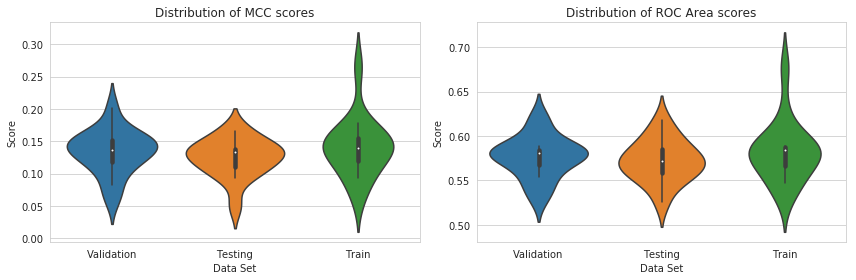

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

columns = ['stock', 'matthews_gru', 'roc_auc_gru', 
           'test_matthews_gru', 'test_roc_auc_gru', 'train_matthews_gru', 'train_roc_auc_gru']

df = df_best[columns].copy()
df.rename(columns={
    'matthews_gru': 'Validation', 'test_matthews_gru': 'Testing', 'train_matthews_gru': 'Train'}, inplace=True)
df = df.melt(['stock', 'roc_auc_gru', 'test_roc_auc_gru', 'train_roc_auc_gru'])
sns.violinplot(x="variable", y="value", data=df, ax=ax1)
ax1.set_title('Distribution of MCC scores')

ax1.set_xlabel('Data Set')
ax1.set_ylabel('Score')

df = df_best[columns].copy()
df.rename(columns={'roc_auc_gru': 'Validation', 'test_roc_auc_gru': 'Testing', 'train_roc_auc_gru': 'Train'}, inplace=True)
df = df.melt(['stock', 'matthews_gru', 'test_matthews_gru', 'train_matthews_gru'])

ax2.set_title('Distribution of ROC Area scores')

sns.violinplot(x="variable", y="value", data=df, ax=ax2)
ax2.set_xlabel('Data Set')
ax2.set_ylabel('Score')

plt.tight_layout()
if if_should_savefig:
    plt.savefig('violin_distribution_scores_gdf_pca_gru.png')

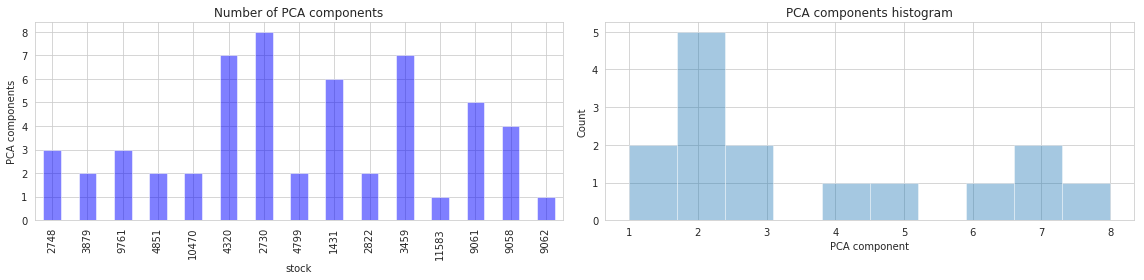

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
df_best['pca_components'].plot(kind='bar', color=['b'], alpha=0.5, ax=ax1)
ax1.set_title('Number of PCA components')
ax1.set_ylabel('PCA components')

sns.distplot(df_best['pca_components'], ax=ax2, bins=10, kde=False)
ax2.set_title('PCA components histogram')
ax2.set_ylabel('Count')
ax2.set_xlabel('PCA component')


plt.tight_layout()
if if_should_savefig:
    plt.savefig('gdf_pca_gru_pca_components.png')

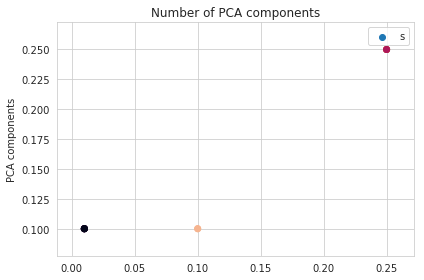

In [15]:
plt.scatter(x=df_best['r'], y=df_best['s'], c=df_best['pca_components'])
plt.title('Number of PCA components')
plt.ylabel('PCA components')
plt.legend()
plt.tight_layout()
if if_should_savefig:
    plt.savefig('gdf_pca_gru_pca_components_scatter.png')

Text(0.5,1,'MCC score distribution for different r and s parameters for validation set')

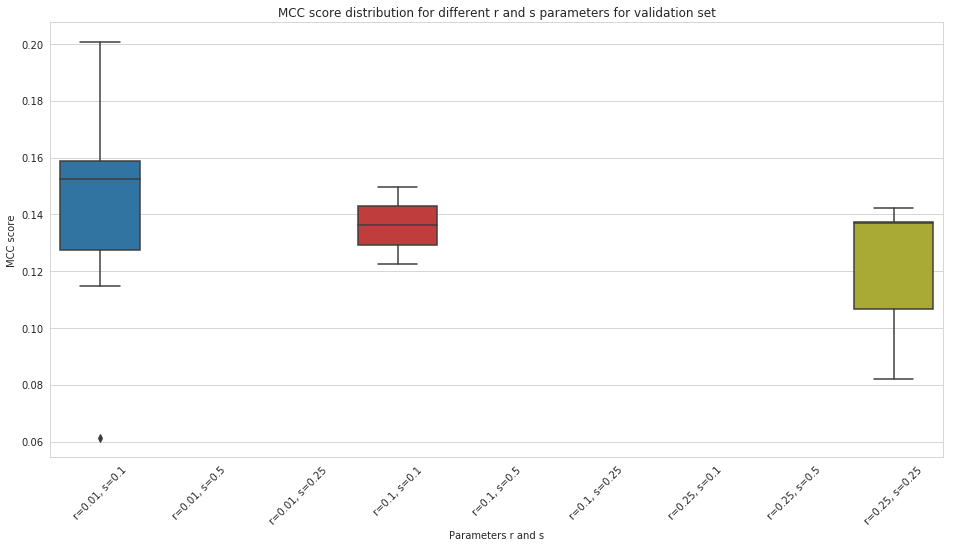

In [16]:
r_s_dict = OrderedDict()
r_parameters = [0.01, 0.1, 0.25]
s_parameters = [0.1, 0.5, 0.25]
for r in r_parameters:
    for s in s_parameters:
        r_s_dict['r={}, s={}'.format(r, s)] = df_best[df_best['r'] == r][df_best['s'] == s][
            'matthews_gru'].values

plt.figure(figsize=(16, 8))
ax = sns.boxplot(data=list(r_s_dict.values()))
plt.ylabel('MCC score')
plt.xlabel('Parameters r and s')
_ = ax.set_xticklabels(list(r_s_dict.keys()), rotation=45)
plt.title('MCC score distribution for different r and s parameters for validation set')

## Comparision with QUE+LOG

In [17]:
df_best['diff_test_matthews'] = df_best['test_matthews_gru'] - df_best['test_matthews_log']
df_best['diff_train_matthews'] = df_best['train_matthews_gru'] - df_best['train_matthews_log']
df_best['diff_matthews'] = df_best['matthews_gru'] - df_best['matthews_log']
df_best['diff_test_roc_auc'] = df_best['test_roc_auc_gru'] - df_best['test_roc_auc_log']
df_best['diff_train_roc_auc'] = df_best['train_roc_auc_gru'] - df_best['train_roc_auc_log']
df_best['diff_roc_auc'] = df_best['roc_auc_gru'] - df_best['roc_auc_log']

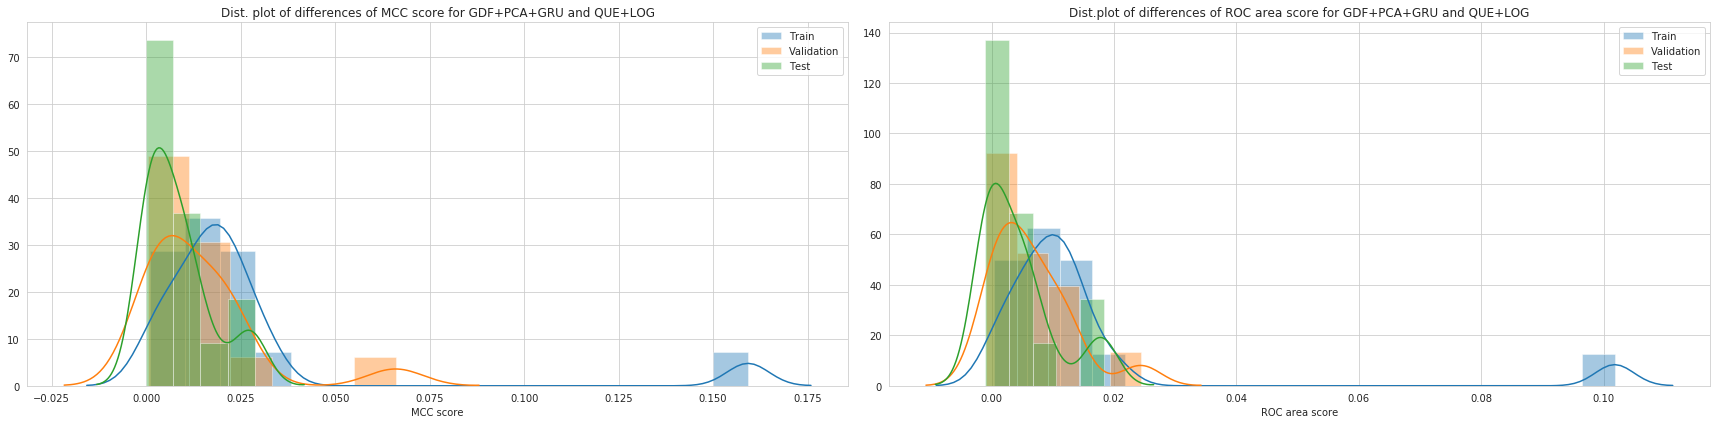

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6))
sns.distplot(df_best['diff_train_matthews'], label='Train', ax=ax1)
sns.distplot(df_best['diff_matthews'], label='Validation', ax=ax1)
sns.distplot(df_best['diff_test_matthews'], label='Test', ax=ax1)
ax1.set_title('Dist. plot of differences of MCC score for GDF+PCA+GRU and QUE+LOG')
ax1.set_xlabel('MCC score')
ax1.legend(['Train', 'Validation', 'Test'])

sns.distplot(df_best['diff_train_roc_auc'], label='Train', ax=ax2)
sns.distplot(df_best['diff_roc_auc'], label='Validation', ax=ax2)
sns.distplot(df_best['diff_test_roc_auc'], label='Test', ax=ax2)
ax2.set_title('Dist.plot of differences of ROC area score for GDF+PCA+GRU and QUE+LOG')
ax2.legend(['Train', 'Validation', 'Test'])
ax2.set_xlabel('ROC area score')
plt.tight_layout()
if if_should_savefig:
    plt.savefig('gdf_pca_gru_and_que_log_score_diff.png')

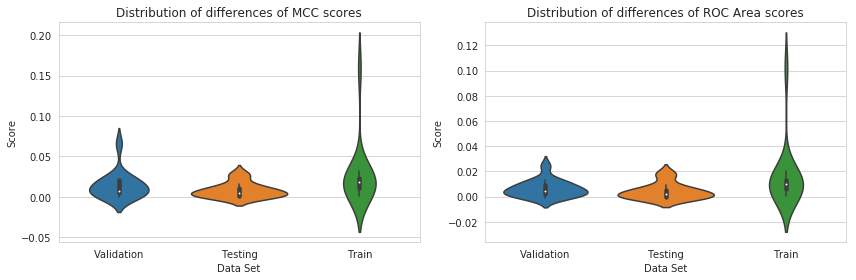

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

columns = ['stock', 'diff_matthews', 'diff_roc_auc', 
           'diff_test_matthews', 'diff_test_roc_auc', 'diff_train_matthews', 'diff_train_roc_auc']

df = df_best[columns].copy()
df.rename(columns={
    'diff_matthews': 'Validation', 'diff_test_matthews': 'Testing', 'diff_train_matthews': 'Train'}, inplace=True)
df = df.melt(['stock', 'diff_roc_auc', 'diff_test_roc_auc', 'diff_train_roc_auc'])
sns.violinplot(x="variable", y="value", data=df, ax=ax1)
ax1.set_title('Distribution of differences of MCC scores')

ax1.set_xlabel('Data Set')
ax1.set_ylabel('Score')

df = df_best[columns].copy()
df.rename(
    columns={'diff_roc_auc': 'Validation', 'diff_test_roc_auc': 'Testing', 'diff_train_roc_auc': 'Train'}, 
    inplace=True)
df = df.melt(['stock', 'diff_matthews', 'diff_test_matthews', 'diff_train_matthews'])

ax2.set_title('Distribution of differences of ROC Area scores')

sns.violinplot(x="variable", y="value", data=df, ax=ax2)
ax2.set_xlabel('Data Set')
ax2.set_ylabel('Score')

plt.tight_layout()
if if_should_savefig:
    plt.savefig('gdf_pca_gru_and_que_log_violin_score_diff.png')

In [20]:
bad = df_best[df_best['test_matthews_gru'] < df_best['test_matthews_log']]['stock'].values

In [21]:
df_best[['diff_train_matthews', 'diff_matthews', 'diff_test_matthews', 
        'diff_train_roc_auc', 'diff_roc_auc', 'diff_test_roc_auc']][df_best['stock'].isin(bad)]

,diff_train_matthews,diff_matthews,diff_test_matthews,diff_train_roc_auc,diff_roc_auc,diff_test_roc_auc
stock,,,,,,
3879,0.019537,0.022197,-0.000129,0.010884,0.01229,-0.000303


In [22]:
df_best[['diff_train_matthews', 'diff_matthews', 'diff_test_matthews', 
        'diff_train_roc_auc', 'diff_roc_auc', 'diff_test_roc_auc']][df_best['stock'].isin(bad)].describe()

,diff_train_matthews,diff_matthews,diff_test_matthews,diff_train_roc_auc,diff_roc_auc,diff_test_roc_auc
count,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000
mean,0.019537,0.022197,-0.000129,0.010884,0.01229,-0.000303
std,NaN,NaN,NaN,NaN,NaN,NaN
min,0.019537,0.022197,-0.000129,0.010884,0.01229,-0.000303
25%,0.019537,0.022197,-0.000129,0.010884,0.01229,-0.000303
50%,0.019537,0.022197,-0.000129,0.010884,0.01229,-0.000303
75%,0.019537,0.022197,-0.000129,0.010884,0.01229,-0.000303
max,0.019537,0.022197,-0.000129,0.010884,0.01229,-0.000303


In [23]:
df_best[['diff_train_matthews', 'diff_matthews', 'diff_test_matthews', 
        'diff_train_roc_auc', 'diff_roc_auc', 'diff_test_roc_auc']].describe()

,diff_train_matthews,diff_matthews,diff_test_matthews,diff_train_roc_auc,diff_roc_auc,diff_test_roc_auc
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,0.026163,0.014293,0.008543,0.015505,0.006520,0.004409
std,0.037867,0.016377,0.009075,0.024435,0.006611,0.006262
min,0.000934,0.000407,-0.000129,0.000468,-0.000862,-0.001059
25%,0.011333,0.004622,0.001470,0.006343,0.002100,-0.000401
50%,0.018591,0.007004,0.004796,0.010152,0.004812,0.002377
75%,0.023496,0.020764,0.010938,0.013270,0.009291,0.005522
max,0.159230,0.065961,0.028846,0.101819,0.024389,0.018385


In [24]:
print(df_best[df_best['test_roc_auc_gru'] < df_best['test_roc_auc_log']]['stock'].values)

[3879 4320 1431 3459 9058]


In [25]:
print(list(df_best[df_best['test_matthews_gru'] < df_best['test_matthews_log']]['stock'].values))

[3879]


In [26]:
columns = ['stock'] + [c for c in df_best.columns if 'matthews' in c]
df_best[columns + ['arch']]

for i, row in df_best.iterrows():
    
    m = model_from_json(row['arch'])

    from keras.utils import plot_model
    st = row['stock']
    r = row['r']
    s = row['s']
    if if_should_savefig:
        plot_model(m, show_layer_names=True, show_shapes=True, to_file=f'plot_model_gru/model_{st}_r{r}_s{s}.png')